# Introduction
This notebook goes from (preprocessed) EEG data extraction to the fit of the HsMM-MVPA model in multiple conditions

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import itertools
import multiprocessing
import os
from mne.decoding import UnsupervisedSpatialFilter
import pyhsmm_mvpa as hsmm

cpus = multiprocessing.cpu_count()
print(cpus)

%load_ext autoreload
%autoreload 2


16


The following cells allow you to restrict the analysis to a subset of the participants. THis will ease the computational load on your machine but will be removed for the final analysis

# Loading EEG data
Then resample and create epochs (i.e. trial where time 0 is the time at which the stimulus appeared) and store in common xarray file (see https://docs.xarray.dev/en/stable/ for more info on that format)

In [2]:
hsmm.read_mne_EEG

<function pyhsmm_mvpa.read_mne_EEG(pfiles, event_id, resp_id, sfreq, events=None, resampling=False, tmin=-0.2, tmax=2.2, offset_after_resp=0.1, low_pass=0.5, high_pass=30, upper_limit_RT=2, lower_limit_RT=0.2)>

In [3]:
event_id = {'accuracy/left/1':211,'accuracy/left/2':212,'accuracy/left/3':213,
           'accuracy/right/1':221,'accuracy/right/2':222,'accuracy/right/3':223,
            'speed/left/1':111,'speed/left/2':112,'speed/left/3':113, #conditions in the experiment
           'speed/right/1':121,'speed/right/2':122,'speed/right/3':123} # used for segmentation
resp_id = {'r_left':100,'r_right':200}#Response events
sfreq = 100#For resampling
#cpus = 2 #if not enough RAM to load all participants data, better reduce the number of processes

path = '/home/gweindel/owncloud/projects/PHD/ForceEEG_2021/processing_EEG/preprocessed_data/'
subj_names = [x.split('_')[1].split('.')[0] for x in os.listdir(path) if 'preprocessed' in x]
subj_names = ['S1', 'S2','S3','S4', 'S5']#subset for the example, remove for analysis
print(subj_names)
subj_files = [path+ 'preprocessed_'+x+'.fif' for x in subj_names]

save_file = 'epoch_data_condition-wise.nc'
if save_file not in os.listdir():#avoids to loop again if notebook is restarted
    with multiprocessing.Pool(processes=cpus) as pool:
        epoch_data = pool.starmap(hsmm.read_mne_EEG, 
                zip([[x] for x in subj_files], itertools.repeat(event_id), itertools.repeat(resp_id),
                    itertools.repeat(sfreq)))
    epoch_data = xr.concat(epoch_data, pd.Series(subj_names, name="participant"))#not sure about the order of the particiapnt use with caution
    epoch_data.to_netcdf(save_file)
    epoch_data = xr.open_dataset(save_file)#For an unknown reason I need to re-read it
else:
    epoch_data = xr.open_dataset(save_file)

['S1', 'S2', 'S3', 'S4', 'S5']


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:35: RuntimeWarning: This filename (/home/gweindel/owncloud/projects/PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data = mne.io.read_raw_fif(participant, preload=False, verbose=False)
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:35: RuntimeWarning: This filename (/home/gweindel/owncloud/projects/PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data = mne.io.read_raw_fif(participant, preload=False, verbo

Reading 0 ... 6117375  =      0.000 ...  5973.999 secs...
Reading 0 ... 4689919  =      0.000 ...  4579.999 secs...
Reading 0 ... 4573183  =      0.000 ...  4465.999 secs...
Reading 0 ... 4750335  =      0.000 ...  4638.999 secs...
Reading 0 ... 5378047  =      0.000 ...  5251.999 secs...
Downsampling to 100 Hz
Downsampling to 100 Hz
Downsampling to 100 Hz
Downsampling to 100 Hz
Downsampling to 100 Hz


In [4]:
epoch_data

<xarray.Dataset>
Dimensions:      (epochs: 2355, samples: 199, participant: 5, electrodes: 64)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 ... 2349 2350 2351 2352 2353 2354
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198
  * electrodes   (electrodes) object 'Fp1' 'AF7' 'AF3' 'F1' ... 'PO8' 'PO4' 'O2'
  * participant  (participant) object 'S1' 'S2' 'S3' 'S4' 'S5'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 ...
    event        (participant, epochs) object ...
Attributes:
    sfreq:    100.0

# Applying HsMM for the speed condition

Initializing data for the speed condition

In [7]:
subset = epoch_data.where(epoch_data.event.str.contains('speed'),drop=True)
hsmm_speed_data = hsmm.transform_data(subset,\
                           'participant',stack=True,return_weights=True)
init_speed = hsmm.hsmm(hsmm_speed_data.data.T, hsmm_speed_data.starts.data, hsmm_speed_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

In [8]:
file_to_save = 'bests_speed.nc'

if file_to_save not in os.listdir():
    bests_speed = init_speed.backward_estimation()
    bests_speed.to_netcdf(file_to_save)
else:
    bests_speed = xr.open_dataset(file_to_save)
    print('recovering previous estimation')
bests_speed

Estimating parameters for 4 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:353: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:359: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 4 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 4, stage: 5, params: 2, component: 10, bump: 4,
                  samples: 153, trial: 5086)
Coordinates:
  * n_bumps      (n_bumps) int64 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -2.438e+04 -1.815e+04 -1.837e+04 -1.948e+04
    parameters   (n_bumps, stage, params) float64 2.0 2.694 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.409 0.439 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

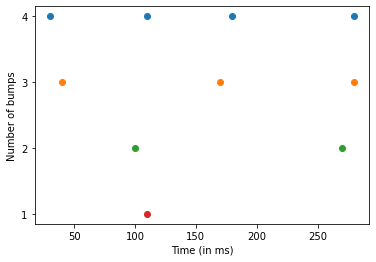

In [9]:
for nbump in np.arange(init_speed.max_bumps,0,-1):
    times = init_speed.mean_bump_times(bests_speed.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
plt.xlabel('Time (in ms)')
plt.yticks(np.arange(init_speed.max_bumps)+1)
plt.ylabel('Number of bumps');

In [10]:
#Looping over possible number of bumps
subjects_idx = epoch_data.participant.values
likelihoods_loo = []

temp = hsmm_speed_data.unstack().data
bests = bests_speed
init = init_speed

all_n_bumps = []
for n_bumps in np.arange(1,init_speed.max_bumps+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
    all_n_bumps.append(loo)
    
all_n_bumps_speed = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init_speed.max_bumps+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})

all_n_bumps_speed.to_netcdf('all_n_bumps_speed.nc')

Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Parameters estimated for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 3 bumps model
Parameters 

In [26]:
all_n_bumps_speed

<xarray.DataArray (n_bump: 4, participants: 5)>
array([[-4391.72631253, -3187.13502284, -5105.30723533, -3251.72500514,
        -4840.85800751],
       [-3707.70219269, -3289.04602142, -5503.47181925, -3478.65725517,
        -4749.26238609],
       [-3556.89970897, -2550.77729252, -4272.3197403 , -3633.81001395,
        -4132.91032537],
       [-5680.15976656, -4306.90175688, -7104.61815235, -4606.54391998,
        -6041.12203227]])
Coordinates:
  * n_bump        (n_bump) int64 1 2 3 4
  * participants  (participants) <U32 'S1' 'S2' 'S3' 'S4' 'S5'

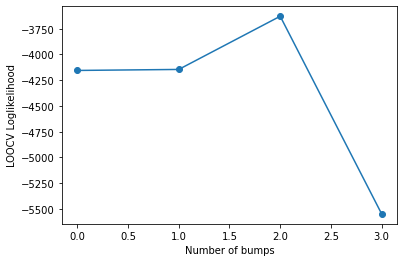

In [25]:
plt.plot(np.arange(init_speed.max_bumps),np.mean(np.array(all_n_bumps_speed),axis=1),'o-')
plt.ylabel('LOOCV Loglikelihood')
plt.xlabel('Number of bumps');

# Applying HsMM for the accuracy condition

Initializing data for the accuracy condition

In [12]:
subset = epoch_data.where(epoch_data.event.str.contains('accuracy'),drop=True)
hsmm_accuracy_data = hsmm.transform_data(subset,'participant',stack=True,return_weights=True)
init_accuracy = hsmm.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

In [13]:
init_accuracy = hsmm.hsmm(hsmm_accuracy_data.data.T, hsmm_accuracy_data.starts.data, hsmm_accuracy_data.ends.data, 
                       sf=epoch_data.sfreq, cpus=cpus)

Estimating the different number of bump solution using the backward estimation (first estimate max_bump solution then estimate max_bump - 1 solution by iteratively removing one of the bump and pick the one with the highest likelihood)

In [14]:
file_to_save = 'bests_accuracy.nc'

if file_to_save not in os.listdir():
    bests_accuracy = init_accuracy.backward_estimation()
    bests_accuracy.to_netcdf(file_to_save)
else:
    bests_accuracy = xr.open_dataset(file_to_save)
    print('recovering previous estimation')
bests_accuracy

Estimating parameters for 4 bumps model


/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:353: UserWarning: Using default parameters value for gamma parameters
  warnings.warn('Using default parameters value for gamma parameters')
/home/gweindel/owncloud/projects/RUGUU/pyhsmm-mvpa/pyhsmm_mvpa.py:359: UserWarning: Using default parameters value for magnitudes
  warnings.warn('Using default parameters value for magnitudes')


Parameters estimated for 4 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model


<xarray.Dataset>
Dimensions:      (n_bumps: 4, stage: 5, params: 2, component: 10, bump: 4,
                  samples: 199, trial: 5099)
Coordinates:
  * n_bumps      (n_bumps) int64 4 3 2 1
Dimensions without coordinates: stage, params, component, bump, samples, trial
Data variables:
    likelihoods  (n_bumps) float64 -2.228e+04 -1.994e+04 -2.019e+04 -2.121e+04
    parameters   (n_bumps, stage, params) float64 2.0 3.459 2.0 ... nan nan nan
    magnitudes   (n_bumps, component, bump) float64 -0.3493 -0.5364 ... nan nan
    eventprobs   (n_bumps, samples, trial, bump) float64 0.0 0.0 0.0 ... nan nan

## Plotting the bump placement from this method

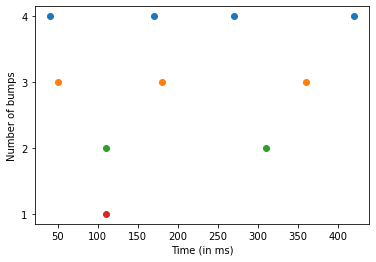

In [15]:
for nbump in np.arange(init_accuracy.max_bumps,0,-1):
    times = init_accuracy.mean_bump_times(bests_accuracy.sel(n_bumps=nbump))
    plt.plot(times, np.repeat(nbump, len(times)),'o')
plt.xlabel('Time (in ms)')
plt.yticks(np.arange(init_accuracy.max_bumps)+1)
plt.ylabel('Number of bumps');

In [16]:
#Looping over possible number of bumps
subjects_idx = epoch_data.participant.values
likelihoods_loo = []

temp = hsmm_accuracy_data.unstack().data
bests = bests_accuracy
init = init_accuracy

all_n_bumps = []
for n_bumps in np.arange(1,init_accuracy.max_bumps+1):    
    with multiprocessing.Pool(processes=cpus) as pool:
        loo = pool.starmap(hsmm.LOOCV, 
            zip(itertools.repeat(temp),subjects_idx, itertools.repeat(n_bumps), 
                itertools.repeat(bests.sel(n_bumps=n_bumps)), itertools.repeat(epoch_data.sfreq)))
    all_n_bumps.append(loo)
    
all_n_bumps_accuracy = xr.DataArray(np.array(all_n_bumps)[:,:,0].astype(np.float64), coords={"n_bump":np.arange(1,init_accuracy.max_bumps+1),
                                                           "participants":np.array(all_n_bumps)[0,:,1]})

all_n_bumps_accuracy.to_netcdf('all_n_bumps_accuracy.nc')

Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Parameters estimated for 1 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Estimating parameters for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Parameters estimated for 2 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Estimating parameters for 3 bumps model
Parameters estimated for 3 bumps model
Estimating parameters for 3 bumps model
Parameters 

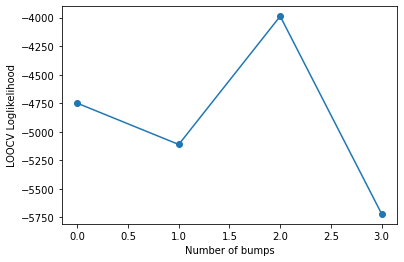

In [24]:
plt.plot(np.arange(init_accuracy.max_bumps),np.mean(np.array(all_n_bumps_accuracy),axis=1),'o-')
plt.ylabel('LOOCV Loglikelihood')
plt.xlabel('Number of bumps');

# Inspecting best model

In [27]:
estimates_speed = bests_speed.sel(n_bumps=3)

In [28]:
estimates_accuracy = bests_accuracy.sel(n_bumps=3)

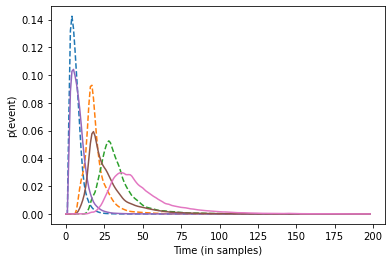

In [29]:
plt.plot(estimates_speed.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2,3]),'--')
plt.plot(estimates_accuracy.eventprobs.mean(dim=['trial']).sel(bump=[0,1,2,3]))
plt.ylabel('p(event)')
plt.xlabel('Time (in samples)');

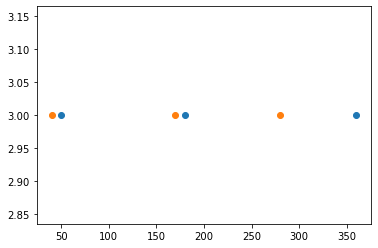

In [30]:
times = init_accuracy.mean_bump_times(estimates_accuracy)
plt.plot(times, np.repeat(3, len(times)),'o')
times = init_accuracy.mean_bump_times(estimates_speed)
plt.plot(times, np.repeat(3, len(times)),'o')

/tmp/ipykernel_109656/3201722652.py:2: RuntimeWarning: This filename (/home/gweindel/owncloud/projects/PHD/ForceEEG_2021/processing_EEG/preprocessed_data/preprocessed_S1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(subj_files[0], preload=False, verbose=False)


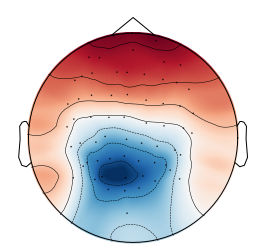

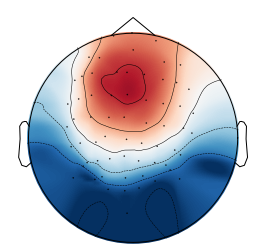

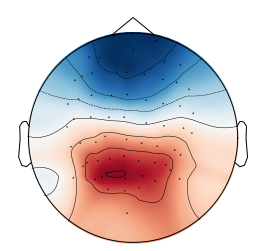

In [31]:
import mne
raw = mne.io.read_raw_fif(subj_files[0], preload=False, verbose=False)
for bump in estimates_speed.magnitudes.dropna(dim='bump').T:
    mne.viz.plot_topomap(hsmm_speed_data.PCs@bump, raw.pick_types(eeg=True).info)

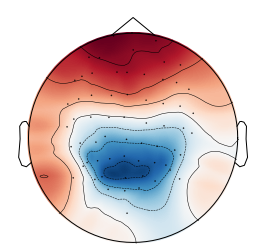

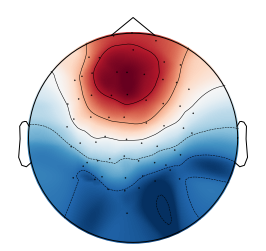

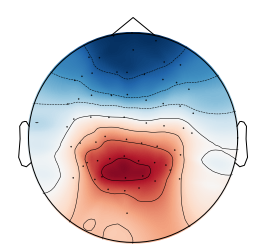

In [32]:
for bump in estimates_accuracy.magnitudes.dropna(dim='bump').T:
    mne.viz.plot_topomap(hsmm_accuracy_data.PCs@bump, raw.pick_types(eeg=True).info)